In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -qq "/content/drive/MyDrive/UTKFace.zip" -d "/content/UTKFace"

In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, accuracy_score
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [9]:
DATA_DIR = "/content/UTKFace/UTKFace"

#Redimensionnement
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Visualisation de la répartition Homme - Femme

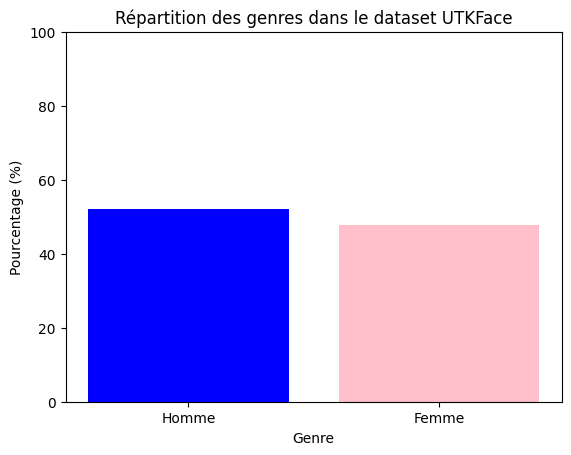

In [ ]:
file_names = os.listdir(DATA_DIR)
sex_labels = []
for file in file_names:
    # Le format est "age_sexe_ethnie_dateNaiss.jpg"
    parts = file.split('_')
    if len(parts) > 1:  # Vérifie que le format est correct
        sex_labels.append(int(parts[1]))  # Le deuxième élément est le sexe (0 = Homme, 1 = Femme)

# Compter les occurrences pour chaque sexe
labels, counts = np.unique(sex_labels, return_counts=True)

# Convertir les occurrences en pourcentages
percentages = (counts / counts.sum()) * 100

# Noms des classes
class_names = ["Homme", "Femme"]

# Visualisation en graphique à barres
plt.bar(class_names, percentages, color=['blue', 'pink'])
plt.title("Répartition des genres dans le dataset UTKFace")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Genre")
plt.ylim(0, 100)  # Limiter l'axe des ordonnées de 0 à 100
plt.show()

Il y a presque autant d'homme que de femme : le dataset n'aura pas besoin de manipulations spéciales pour gérer un déséquilibre de classes.

# Traitement des images d'UTKFace

In [ ]:
#TRAITEMENT DE L'IMAGE

def load_data(data_dir=DATA_DIR):
    X = [] #liste d'img après traitement convertit en NumPY
    y = [] #liste contenant les genres

    # Récup tts les img dans UTKFace
    file_names = os.listdir(data_dir)

    for file in file_names:
        # nom de fichier type "age_sexe_ethnie_dateNaiss.jpg"
        # On récupère le deuxième champ pour le genre
        # 0 => Homme, 1 => Femme
        parts = file.split("_")
        gender_str = parts[1]
        try:
            gender = int(gender_str)
        except:
            continue

        # lecture
        img_path = os.path.join(data_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # conversion en RGB (cv2 lit en BGR par défaut)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # redimension
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        # Normalisation
        img = img.astype("float32") / 255.0

        X.append(img)
        y.append(gender)

    return np.array(X), np.array(y)

# Chargement des données
X, y = load_data(DATA_DIR)

print("Nombre d'images chargées :", len(X))
print("Dimension de X :", X.shape)
print("Dimension de y :", y.shape)

Nombre d'images chargées : 23708
Dimension de X : (23708, 64, 64, 3)
Dimension de y : (23708,)


# Division du jeu de données

In [ ]:
#DIVISER LE JEU DE DONN2ES :

# 1. Jeu d'entraînement (X_train, y_train) : utilisé pour entraîner le modèle.
    #Jeu de test (X_test, y_test) : utilisé pour évaluer les performances du modèle sur des données qu'il n'a jamais vues.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% pour le jeu de test
    stratify=y         # Proportions de classes respectées
)

# 2. Séparer l'entraînement en sous-ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 10% de l'entraînement pour la validation
    stratify=y_train
)

print("Taille du jeu d'entraînement :", X_train.shape, len(y_train))
print("Taille du jeu de test :", X_test.shape, len(y_test))

Taille du jeu d'entraînement : (15172, 64, 64, 3) 15172
Taille du jeu de test : (4742, 64, 64, 3) 4742


# Modèle V1

In [ ]:
# PREMIER ESSAI : OBSERVATION

def build_model_v1(input_shape=(64, 64, 3)):
    model = Sequential([
        Input(shape=input_shape),                 # Entrée du réseau (images 64 x 64 en RGB)

        Conv2D(16, (3, 3), activation='relu'),    # Convolution: 16 filtres, kernel 3x3, activation ReLU
        MaxPooling2D((2, 2)),                     # MaxPooling: réduit la dimension spatiale de moitié (64→32)

        Flatten(),                                # Aplatissement pour passer de la partie "convolutive" à la partie "dense"

        Dense(16, activation='relu'),             # Couche fully-connected (dense) avec 16 neurones
        Dense(1, activation='sigmoid')            # Couche de sortie: 1 neurone pour la classification binaire (Homme/Femme)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),      # Optimiseur Adam, taux d'apprentissage de 0.001
        loss='binary_crossentropy',               # Fonction de perte adaptée à un problème de classification binaire
        metrics=['accuracy']                      # Métrique principale: accuracy
    )
    return model


model_v1 = build_model_v1((64, 64, 3))
model_v1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15376)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         246,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,497 (962.88 KB)

 Trainable params: 246,497 (962.88 KB)

 Non-trainable params: 0 (0.00 B)

Dans cette première expérimentation (V1), nous avons conçu un réseau de neurones convolutionnel (CNN) simple afin d’effectuer une classification binaire (Homme vs Femme) sur le dataset UTKFace. L’objectif principal est d’observer les performances de cette architecture de base avant d’envisager un modèle final et plus complexe.

Les images sont redimensionnées en 64×64 pixels et converties en RGB (3 canaux). Une taille plus grande nécessiterait plus de ressources mémoire et de puissance de calcul, tandis qu’une taille plus petite pourrait entraîner une perte d’information.

L’architecture du réseau final est construite en suivant une approche progressive. La première couche est une convolution ```Conv2D(16, (3,3), activation='relu')``` qui applique 16 filtres de taille 3×3 pour extraire des caractéristiques locales comme les bords de visage et les textures. L’activation ReLU est utilisée pour introduire de la non-linéarité et améliorer la convergence. Le nombre de filtres est volontairement limité pour cette observation.

La couche de pooling ```MaxPooling2D((2,2))```  permet de réduire la dimension spatiale des images en divisant leur taille par deux. Cette réduction diminue le nombre de paramètres du modèle, limite le risque de surapprentissage et résume l’information en conservant les caractéristiques les plus importantes.

La couche ```Flatten()``` transforme ensuite la sortie des couches convolutionnelles en un vecteur unidimensionnel, pour le passage aux couches fully connected.

La couche dense ```Dense(16, activation='relu')``` est ajoutée pour combiner les caractéristiques extraites précédemment.

Enfin, la couche de sortie ```Dense(1, activation='sigmoid')``` contient un seul neurone activé par une fonction sigmoïde, adaptée à une classification binaire. Puisqu’il s’agit d’une classification binaire (Homme vs Femme), on a un seul neurone en sortie.
La sortie prend une valeur entre 0 et 1, qu’on interprétera comme la probabilité que l’image soit classée dans la classe « Femme ».


Le modèle est compilé avec l’optimiseur Adam et un taux d’apprentissage de 0.001, ce qui permet une convergence sans nécessiter un réglage manuel du taux d’apprentissage. La fonction de perte choisie est la binary crossentropy, standard pour les tâches de classification binaire. L’accuracy est utilisée comme métrique pour suivre les performances du modèle lors de l’entraînement.

Ce modèle constitue une première approche permettant d’observer comment un CNN, même simple, parvient à traiter la classification des visages dans UTKFace. Son architecture volontairement minimaliste permet d’analyser ses performances initiales avant d’explorer des améliorations telles que l’augmentation du nombre de couches convolutionnelles, l’augmentation de la taille des images d’entrée ou l’intégration de techniques de régularisation comme le Dropout et la Batch Normalization.


In [ ]:
history_v1 = model_v1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 45s 94ms/step - accuracy: 0.7638 - loss: 0.5507 - val_accuracy: 0.8442 - val_loss: 0.4396
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.8412 - loss: 0.4308 - val_accuracy: 0.8611 - val_loss: 0.3800
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.8565 - loss: 0.3812 - val_accuracy: 0.8743 - val_loss: 0.3433
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8659 - loss: 0.3487 - val_accuracy: 0.8648 - val_loss: 0.3372
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8771 - loss: 0.3266 - val_accuracy: 0.8326 - val_loss: 0.3912
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8784 - loss: 0.3148 - val_accuracy: 0.8724 - val_loss: 0.3130
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.8937 - loss: 0.2837 - val_accuracy: 0.8740 - val_loss: 0.3077
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.8960 - loss: 0.2737 - 

In [ ]:
test_loss_v1, test_acc_v1 = model_v1.evaluate(X_test, y_test, verbose=0)
print(f"[V1] Test accuracy: {test_acc_v1:.4f}")

y_pred_prob_v1 = model_v1.predict(X_test)
y_pred_v1 = (y_pred_prob_v1 > 0.5).astype("int32")
print(classification_report(y_test, y_pred_v1, target_names=["Homme", "Femme"]))

[V1] Test accuracy: 0.8762
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
              precision    recall  f1-score   support

       Homme       0.86      0.91      0.88      2478
       Femme       0.89      0.84      0.87      2264

    accuracy                           0.88      4742
   macro avg       0.88      0.87      0.88      4742
weighted avg       0.88      0.88      0.88      4742



Le modèle atteint une bonne accuracy (87.62 %), ce qui est très correct pour une première version.

Le modèle semble mieux détecter les hommes (rappel plus élevé 0.91).
À l’inverse, il a une précision légèrement meilleure sur les femmes (0.89), mais un rappel plus bas (0.84), ce qui signifie qu’il classifie plus souvent un visage féminin comme masculin que l’inverse.

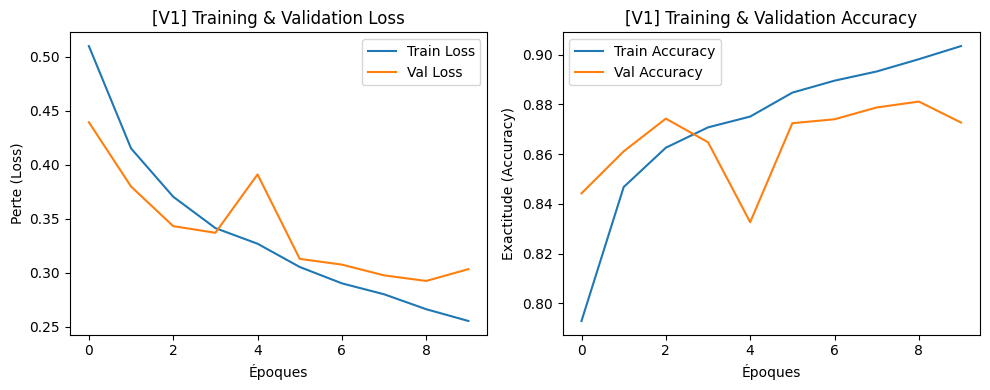

In [ ]:
plt.figure(figsize=(10,4))

# Courbe de la fonction de perte (Loss)
plt.subplot(1,2,1)
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V1] Training & Validation Loss')

# Courbe de l’Accuracy
plt.subplot(1,2,2)
plt.plot(history_v1.history['accuracy'], label='Train Accuracy')
plt.plot(history_v1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V1] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

La loss d'entraînement diminue progressivement au fil des époques, ce qui indique que le modèle apprend bien sur les données d'entraînement.
La loss de validation suit la même tendance globale, mais avec des fluctuations, notamment une hausse autour de l’époque 5, ce qui peut indiquer un début de surapprentissage.
Vers la fin, la loss de validation cesse de diminuer et commence à remonter légèrement, ce qui renforce l’hypothèse d’un léger surapprentissage après plusieurs époques.

La précision sur l'entraînement (train accuracy) augmente continuellement, atteignant 90 %.
La précision de validation (val accuracy) augmente également mais présente une diminution temporaire autour de l’époque 5, avant de remonter.
Une différence commence à apparaître entre les courbes d’entraînement et de validation, surtout vers la fin.

La décroissance temporaire de l’accuracy de validation est un signe que le modèle commence à mémoriser les données d'entraînement plutôt que de généraliser.
Vers la fin de l’entraînement, l’écart entre accuracy d’entraînement et de validation s'agrandit, ce qui confirme le début du surapprentissage.

Ainsi, pour améliorer le modèle, on peut :

- Ajouter plus de bloc pour capturer plus de caractéristiques.
- Augmenter le nombre de filtres.
- Ajouter une couche de Dropout pour éviter que le réseau ne mémorise trop les données d’entraînement.
- Ajouter un EarlyStopping pour arrêter l'entraînement s'il n'y a pas d'amélioration.  

# Modèle V2

In [ ]:
def build_model_v2(input_shape=(64, 64, 3)):
    model = Sequential([
        Input(shape=input_shape),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense agrandie
        Dense(128, activation='relu'),
        Dropout(0.3),  # plus le dropout est grand, plus y'a de la régularisation

        # Sortie binaire (sigmoid pour Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_v2 = build_model_v2((64, 64, 3))
model_v2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 29, 29, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,201 (1.22 MB)

 Trainable params: 318,977 (1.22 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Surveille la val_loss
    patience=5,               # Arrête si pas d'amélioration après 5 époques consécutives
    restore_best_weights=True # Récupère les poids de la meilleure époque
)


history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,         # Nombre max d'époques
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - accuracy: 0.7781 - loss: 0.5551 - val_accuracy: 0.8643 - val_loss: 0.2971
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 80s 168ms/step - accuracy: 0.8786 - loss: 0.2795 - val_accuracy: 0.8669 - val_loss: 0.2953
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 79s 167ms/step - accuracy: 0.8963 - loss: 0.2417 - val_accuracy: 0.8759 - val_loss: 0.2674
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 80s 168ms/step - accuracy: 0.9093 - loss: 0.2170 - val_accuracy: 0.8851 - val_loss: 0.2482
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 81s 165ms/step - accuracy: 0.9248 - loss: 0.1822 - val_accuracy: 0.8872 - val_loss: 0.2433
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - accuracy: 0.9301 - loss: 0.1724 - val_accuracy: 0.8790 - val_loss: 0.2863
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.9386 - loss: 0.1511 - val_accuracy: 0.8853 - val_loss: 0.2711
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - accuracy: 0.9497 - loss: 0

In [ ]:
test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test, y_test, verbose=0)
print(f"[V2] Test Accuracy : {test_acc_v2:.4f}")

# Prédictions et rapport de classification
y_pred_prob_v2 = model_v2.predict(X_test)
y_pred_v2 = (y_pred_prob_v2 > 0.5).astype("int32")

print(classification_report(y_test, y_pred_v2, target_names=["Homme", "Femme"]))

[V2] Test Accuracy : 0.8893
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step
              precision    recall  f1-score   support

       Homme       0.89      0.90      0.89      2478
       Femme       0.89      0.87      0.88      2264

    accuracy                           0.89      4742
   macro avg       0.89      0.89      0.89      4742
weighted avg       0.89      0.89      0.89      4742



Le modèle atteint une bonne accuracy sur le test (88.93 %), ce qui reste stable par rapport à la version précédente. Les métriques de classification montrent une précision équilibrée pour les deux classes (0.89 pour les hommes et les femmes), bien qu'on observe une légère baisse du rappel pour la classe "Femme" (0.87), ce qui indique que le modèle a tendance à classer certaines images féminines comme masculines.

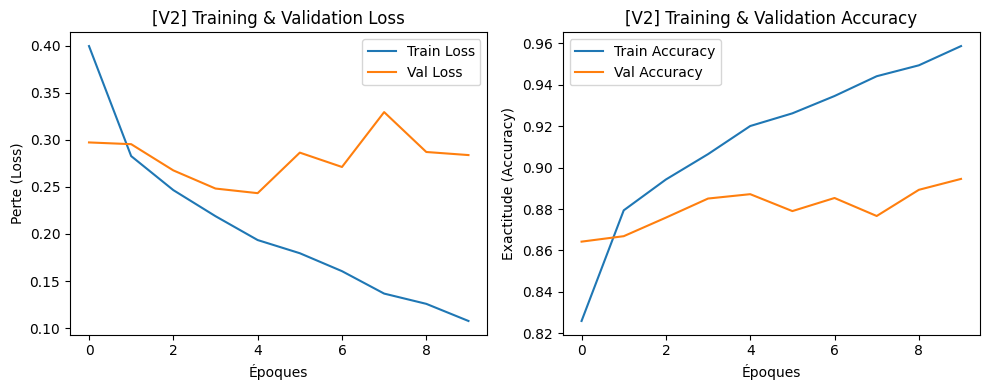

In [ ]:
plt.figure(figsize=(10,4))

# Courbe du loss
plt.subplot(1,2,1)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V2] Training & Validation Loss')

# Courbe de l'accuracy
plt.subplot(1,2,2)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V2] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

La loss d'entraînement diminue progressivement au fil des époques, ce qui indique que le modèle apprend bien sur les données d’entraînement. Cependant, la loss de validation suit une tendance plus fluctuante et commence à remonter légèrement après quelques époques, signe d’un début de surapprentissage. Cette hausse de la perte de validation suggère que le modèle commence à mémoriser les données d'entraînement plutôt qu'à généraliser correctement.

L'accuracy d'entraînement augmente continuellement jusqu’à atteindre environ 96 %, tandis que l'accuracy de validation évolue plus lentement, avec des fluctuations et une progression plus modérée autour de 88-89 %. Une différence commence à apparaître entre ces deux courbes, indiquant que le modèle devient trop spécifique aux données d’entraînement.

La différence entre la loss et l’accuracy d’entraînement et de validation montre que le modèle souffre d’un léger surapprentissage, qui pourrait s’accentuer si l’entraînement se poursuivait.

Ainsi, pour améliorer le modèle, on peut :      
- Ajouter des couches
- Augmenter le Dropout
- Ajouter une autre régularisation (L2)
- Ajuster l'Early stopping
- Augmenter les données pour rendre le modèle plus robuste aux variations

# Modèle V3

In [ ]:
def build_model_v3(input_shape=(64, 64, 3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense + Dropout
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # LR initial
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model_v3 = build_model_v3((64, 64, 3))
model_v3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

In [ ]:
# 3. Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la val_loss
    factor=0.5,          # Divise le LR par 2
    patience=3,          # Après 3 époques sans amélioration
    min_lr=1e-5          # LR plancher
)


history_v3 = model_v3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # Nombre max d'époques
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 124s 249ms/step - accuracy: 0.7008 - loss: 0.6607 - val_accuracy: 0.7934 - val_loss: 0.4416 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 121s 254ms/step - accuracy: 0.8140 - loss: 0.4086 - val_accuracy: 0.7826 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 118s 249ms/step - accuracy: 0.8377 - loss: 0.3721 - val_accuracy: 0.8458 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 142s 250ms/step - accuracy: 0.8470 - loss: 0.3441 - val_accuracy: 0.8458 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 144s 254ms/step - accuracy: 0.8498 - loss: 0.3375 - val_accuracy: 0.8376 - val_loss: 0.3677 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 142s 253ms/step - accuracy: 0.8673 - loss: 0.3061 - val_accuracy: 0.8595 - val_loss: 0.3123 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 124s 260ms/step - accura

In [ ]:
test_loss_v3, test_acc_v3 = model_v3.evaluate(X_test, y_test, verbose=0)
print(f"[V3] Test Loss : {test_loss_v3:.4f}")
print(f"[V3] Test Accuracy : {test_acc_v3:.4f}")

# Prédictions & rapport de classification
y_pred_prob_v3 = model_v3.predict(X_test)
y_pred_v3 = (y_pred_prob_v3 > 0.5).astype("int32")

print(classification_report(y_test, y_pred_v3, target_names=["Homme", "Femme"]))

[V3] Test Loss : 0.2246
[V3] Test Accuracy : 0.9123
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step
              precision    recall  f1-score   support

       Homme       0.92      0.91      0.92      2478
       Femme       0.90      0.91      0.91      2264

    accuracy                           0.91      4742
   macro avg       0.91      0.91      0.91      4742
weighted avg       0.91      0.91      0.91      4742



Le modèle V3 obtient une accuracy de 91.23 % sur l’ensemble de test, ce qui représente une amélioration notable par rapport aux versions précédentes. Les métriques de classification indiquent une bonne équilibre entre précision et rappel :

Précision : 92 % pour la classe "Homme" et 90 % pour la classe "Femme".

Rappel : 91 % pour les deux classes.

F1-score : 92 % pour "Homme" et 91 % pour "Femme".

Ces résultats montrent que le modèle a amélioré sa capacité à bien classifier les deux classes, avec une balance plus stable entre précision et rappel.



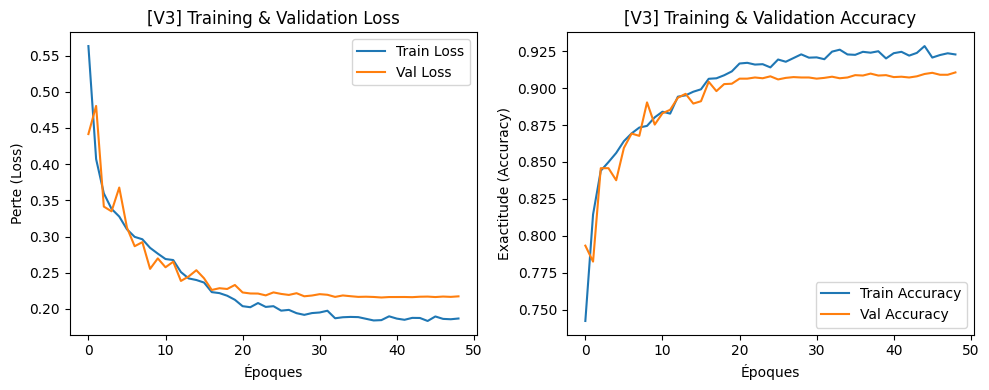

In [ ]:
plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V3] Training & Validation Loss')

# Courbe d’accuracy
plt.subplot(1,2,2)
plt.plot(history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V3] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

La perte d’entraînement diminue régulièrement au fil des époques, ce qui montre que le modèle apprend efficacement.
La perte de validation suit une tendance similaire, avec quelques fluctuations en début d’entraînement, mais elle reste stable après environ 20 époques.
Contrairement aux versions précédentes, la perte de validation ne remonte pas, ce qui indique que le modèle généralise mieux et présente moins de surapprentissage.

L’accuracy d’entraînement et de validation augmente progressivement, avec une stabilisation autour de 91-92 %.
La courbe de validation reste proche de celle d’entraînement, ce qui montre que le modèle n’a pas trop sur-appris sur les données d'entraînement.
Comparé aux versions précédentes, l’écart entre les deux courbes est réduit, ce qui confirme une meilleure généralisation.

Voyons s'il existe des changements notables en augmentant la taille des images en 200 x 200 dans une V4.

# Modèle V4

In [10]:
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 32
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [11]:
# --- PRÉTRAITEMENT D'UNE IMAGE ---
def preprocess_image(image_path, label):
    """
    Charge une image, la redimensionne en 200x200, et la normalise.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))  # Resize en 200x200
    image = image / 255.0  # Normalisation entre [0,1]
    return image, label

# --- CHARGEMENT DES FICHIERS ---
file_paths = []
labels = []

for file in os.listdir(DATA_DIR):
    parts = file.split("_")
    if len(parts) < 2:
        continue  # Évite les fichiers mal nommés

    try:
        gender = int(parts[1])  # Récupère le genre (0 = Homme, 1 = Femme)
    except:
        continue  # Ignore les erreurs

    file_paths.append(os.path.join(DATA_DIR, file))
    labels.append(gender)

file_paths = np.array(file_paths)
labels = np.array(labels)

print(f"Nombre total d'images : {len(file_paths)}")

# --- SPLIT TRAIN / TEST / VALIDATION ---
X_train, X_test, y_train, y_test = train_test_split(
    file_paths, labels,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VAL_SIZE,
    stratify=y_train,
    random_state=42
)

print(f"Taille du jeu d'entraînement : {len(X_train)}")
print(f"Taille du jeu de validation : {len(X_val)}")
print(f"Taille du jeu de test : {len(X_test)}")

# --- CRÉATION DES DATASETS TF ---
def create_tf_dataset(X, y, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(X_train, y_train)
val_dataset = create_tf_dataset(X_val, y_val)
test_dataset = create_tf_dataset(X_test, y_test)


Nombre total d'images : 23708
Taille du jeu d'entraînement : 15172
Taille du jeu de validation : 3794
Taille du jeu de test : 4742


In [12]:
def build_model_v4(input_shape=(200, 200, 3)):  # images 200x200
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense + Dropout
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # LR initial
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Création du modèle avec images 200x200
model_v4 = build_model_v4((200, 200, 3))
model_v4.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │              

 Total params: 2,458,465 (9.38 MB)

 Trainable params: 2,457,729 (9.38 MB)

 Non-trainable params: 736 (2.88 KB)

In [13]:
# --- CALLBACKS ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# --- ENTRAÎNEMENT ---
history_v4 = model_v4.fit(
    train_dataset,                # On utilise tf.data.Dataset
    validation_data=val_dataset,  # Dataset de validation
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 55s 77ms/step - accuracy: 0.7097 - loss: 0.6660 - val_accuracy: 0.7406 - val_loss: 0.4979 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 70s 64ms/step - accuracy: 0.7972 - loss: 0.4429 - val_accuracy: 0.8276 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8140 - loss: 0.4023 - val_accuracy: 0.8506 - val_loss: 0.3337 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.8299 - loss: 0.3719 - val_accuracy: 0.8263 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8458 - loss: 0.3499 - val_accuracy: 0.8656 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.8550 - loss: 0.3289 - val_accuracy: 0.8735 - val_loss: 0.2854 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8593 - l

[V4] Test Loss : 0.2019
[V4] Test Accuracy : 0.9203
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
              precision    recall  f1-score   support

       Homme       0.93      0.92      0.92      2478
       Femme       0.91      0.92      0.92      2264

    accuracy                           0.92      4742
   macro avg       0.92      0.92      0.92      4742
weighted avg       0.92      0.92      0.92      4742



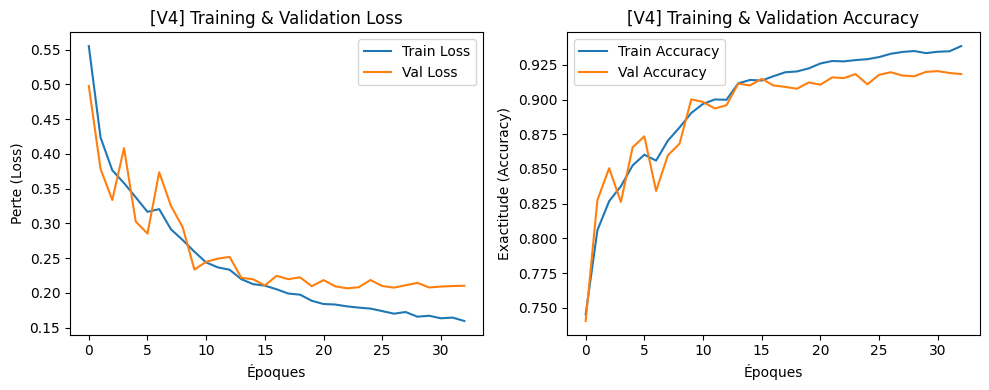

In [14]:
# Évaluation du modèle
test_loss_v4, test_acc_v4 = model_v4.evaluate(test_dataset, verbose=0)
print(f"[V4] Test Loss : {test_loss_v4:.4f}")
print(f"[V4] Test Accuracy : {test_acc_v4:.4f}")

# Génération des prédictions
y_pred_prob_v4 = model_v4.predict(test_dataset)  # Déjà bien formaté

# Convertir les probabilités en classes (0 ou 1)
y_pred_v4 = (y_pred_prob_v4 > 0.5).astype("int32")

# Comme y_test est un array numpy, récupérons les vraies étiquettes du dataset
y_true_v4 = np.concatenate([y for _, y in test_dataset], axis=0)

# Affichage du rapport de classification
print(classification_report(y_true_v4, y_pred_v4, target_names=["Homme", "Femme"]))

plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v4.history['loss'], label='Train Loss')
plt.plot(history_v4.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V4] Training & Validation Loss')

# Courbe d’accuracy
plt.subplot(1,2,2)
plt.plot(history_v4.history['accuracy'], label='Train Accuracy')
plt.plot(history_v4.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V4] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

 En 200x200, le modèle apprend plus vite (convergence en 30 epochs), mais consomme plus de ressources GPU.

 Les performances obtenues en 64x64 et 200x200 sont très proches, avec une accuracy test de 91.2% vs 92.3% et un F1-score quasi identique. Bien que la version 200x200 montre une légère amélioration, l'écart est minime et ne justifie pas forcément l'augmentation du coût de calcul.

 En effet, ici, le modèle 64x64 est plus rapide et consomme moins de ressources tout en atteignant un niveau de précision très similaire.

 Cela s'explique car les images sont de mauvaise qualité. Augmenter la résolution à 200x200 ne va pas  "inventer" des détails supplémentaires. Le CNN va simplement apprendre sur une version plus grande de la même mauvaise qualité.